In [23]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
from src.db import *
from src.objects import *
import IPython
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import random as ran

pd.set_option("display.max_rows", 999)

plt.rcParams['figure.figsize'] = 15.7, 13.27
plt.rcParams['font.family'] = 'AppleGothic'

In [140]:
clean_col_1 = [
    # Meter
    'APT METER','HOUSEHOLD METER','PUBLIC METER','PUBLIC PERCENTAGE',
    # Total
    '종합계약 Total','종합계약 평균청구금액','단일계약 Total','단일계약 평균청구금액',
    # Comprehensive 
    '종합계약 최소요금 가구 (name)','종합계약 최소요금 가구 (kwh)','종합계약 최소요금 가구 (최종청구금액)',
    '종합계약 최소요금 가구 (전기요금)','종합계약 최소요금 가구 (공동설비요금)',
        # MAX
    '종합계약 최대요금 가구 (name)','종합계약 최대요금 가구 (kwh)','종합계약 최대요금 가구 (최종청구금액)',
    '종합계약 최대요금 가구 (전기요금)','종합계약 최대요금 가구 (공동설비요금)',

    # Single
    '단일계약 최소요금 가구 (name)','단일계약 최소요금 가구 (kwh)','단일계약 최소요금 가구 (최종청구금액)',
    '단일계약 최소요금 가구 (전기요금)','단일계약 최소요금 가구 (공동설비요금)',
        # MAX
    '단일계약 최대요금 가구 (name)','단일계약 최대요금 가구 (kwh)','단일계약 최대요금 가구 (최종청구금액)',
    '단일계약 최대요금 가구 (전기요금)','단일계약 최대요금 가구 (공동설비요금)',
]
clean_col_1_ext_1 = [
    # Meter
    'APT METER','PUBLIC METER','종합계약 공동설비요금','단일계약 공동설비요금','종합계약 가구요금 Total','단일계약 가구요금 Total',
    # Total
    '종합계약 Total','단일계약 Total'
]

# 종합계약 비교
clean_col_2 = [
    '종합계약 Total','종합계약 공동설비요금','종합계약 평균청구금액','단일계약 Total','단일계약 공동설비요금','단일계약 평균청구금액',
]

# 최소요금 가구 비교
clean_col_3 = [
    '종합계약 최소요금 가구 (name)','종합계약 최소요금 가구 (kwh)',
    '종합계약 최소요금 가구 (전기요금)','종합계약 최소요금 가구 (공동설비요금)','종합계약 최소요금 가구 (최종청구금액)',
    '단일계약 최소요금 가구 (name)','단일계약 최소요금 가구 (kwh)',
    '단일계약 최소요금 가구 (전기요금)','단일계약 최소요금 가구 (공동설비요금)','단일계약 최소요금 가구 (최종청구금액)',
]

# 최대요금 가구 비교
clean_col_4 = [
    '종합계약 최대요금 가구 (name)','종합계약 최대요금 가구 (kwh)',
    '종합계약 최대요금 가구 (전기요금)','종합계약 최대요금 가구 (공동설비요금)','종합계약 최대요금 가구 (최종청구금액)',
    '단일계약 최대요금 가구 (name)','단일계약 최대요금 가구 (kwh)',
    '단일계약 최대요금 가구 (전기요금)','단일계약 최대요금 가구 (공동설비요금)','단일계약 최대요금 가구 (최종청구금액)',
]

clean_col_5 = [
    # Meter
    'APT METER','HOUSEHOLD METER','PUBLIC METER','PUBLIC PERCENTAGE',
    # Total
    '종합계약 Total','종합계약 평균청구금액','단일계약 Total','단일계약 평균청구금액','최고 누진세 적용량 (kwh)',
    # Comprehensive 
    '종합계약 최소요금 가구 (name)','종합계약 최소요금 가구 (kwh)','종합계약 최소요금 가구 (최종청구금액)',
    '종합계약 최소요금 가구 (전기요금)','종합계약 최소요금 가구 (공동설비요금)',
        # MAX
    '종합계약 최대요금 가구 (name)','종합계약 최대요금 가구 (kwh)','종합계약 최대요금 가구 (최종청구금액)',
    '종합계약 최대요금 가구 (전기요금)','종합계약 최대요금 가구 (공동설비요금)',
    # Single
    '단일계약 최소요금 가구 (name)','단일계약 최소요금 가구 (kwh)','단일계약 최소요금 가구 (최종청구금액)',
    '단일계약 최소요금 가구 (전기요금)','단일계약 최소요금 가구 (공동설비요금)',
        # MAX
    '단일계약 최대요금 가구 (name)','단일계약 최대요금 가구 (kwh)','단일계약 최대요금 가구 (최종청구금액)',
    '단일계약 최대요금 가구 (전기요금)','단일계약 최대요금 가구 (공동설비요금)',
]

progressive_col = [
    '최고 누진세 적용량 (kwh)'
]

In [104]:
basic_households = get_const_households(rate_type="종합계약")
max_household = max(basic_households, key = lambda h: h.kwh)
max_household.kwh += 100
basic_households[4].kwh

410

In [105]:
kepco_report_df = pd.DataFrame()
basic_report_dict = dict()
basic_households = get_const_households(rate_type="종합계약")
now_month = 2

START_STEP = 5
PERCENTAGE_STEP = 5
LAST_STEP = 90
HOUSEHOLD_RATE = sum([_.kwh for _ in basic_households])
HOUSEHOLD_RATE_100 = HOUSEHOLD_RATE * 100

household_name_list = [_.name for _ in basic_households]

for PUBLIC_PERCENTAGE in range(START_STEP, LAST_STEP + PERCENTAGE_STEP, PERCENTAGE_STEP):
    ALL_RATE = round(HOUSEHOLD_RATE_100 / (100 - PUBLIC_PERCENTAGE))
    PUBLIC_RATE = ALL_RATE - HOUSEHOLD_RATE
    
    print("공용 사용량 차지비율: {}%\n".format(PUBLIC_PERCENTAGE) +\
     "세대 사용량 (kwh): {}\n".format(HOUSEHOLD_RATE) +\
     "공용 사용량 (kwh): {}\n".format(PUBLIC_RATE) +\
     "전체 사용량 (kwh): {}\n".format(ALL_RATE))
    
    comprehensive_households = get_const_households(rate_type="종합계약")
    single_households = get_const_households(rate_type="단일계약")

    comp_mgmt = MGMTOFFICE(rate_type="종합계약", 
                      APT_METER=ALL_RATE, 
                      now_month=now_month,
                      households=comprehensive_households)
    single_mgmt = MGMTOFFICE(rate_type="단일계약", 
                      APT_METER=ALL_RATE, 
                      now_month=now_month,
                      households=single_households)
    
    comp_bill = comp_mgmt.bill()
    single_bill = single_mgmt.bill()
    
    mgmt_office_row_name = "[{}월] 관리사무소 청구서".format(now_month)
    public_row_name = "[{}월] 공동사용설비요금".format(now_month)
    households_row_name = "[{}월] 세대 전체 요금 합산".format(now_month)
    
    basic_report_dict['APT METER'] = ALL_RATE
    basic_report_dict['HOUSEHOLD METER'] = HOUSEHOLD_RATE
    basic_report_dict['PUBLIC METER'] = PUBLIC_RATE
    basic_report_dict['PUBLIC PERCENTAGE'] = PUBLIC_PERCENTAGE
    basic_report_dict['종합계약 Total'] = comp_bill.loc[mgmt_office_row_name]['청구금액 (절사)']
    basic_report_dict['종합계약 가구요금 Total'] = comp_bill.loc[households_row_name]['청구금액 (절사)']
    basic_report_dict['종합계약 공동설비요금'] = comp_bill.loc[public_row_name]['청구금액 (절사)']
    basic_report_dict['종합계약 평균청구금액'] = round(comp_bill.loc[household_name_list]['최종청구금액'].mean())
    basic_report_dict['단일계약 Total'] = single_bill.loc[mgmt_office_row_name]['청구금액 (절사)']
    basic_report_dict['단일계약 가구요금 Total'] = single_bill.loc[households_row_name]['청구금액 (절사)']
    basic_report_dict['단일계약 공동설비요금'] = single_bill.loc[public_row_name]['청구금액 (절사)']
    basic_report_dict['단일계약 평균청구금액'] = round(single_bill.loc[household_name_list]['최종청구금액'].mean())
    
    comp_min = comp_bill.loc[household_name_list]['최종청구금액'].min()
    household_name = comp_bill[comp_bill['최종청구금액'] == comp_min].index[0]
    
    basic_report_dict['종합계약 최소요금 가구 (name)'] = household_name
    basic_report_dict['종합계약 최소요금 가구 (kwh)'] = comp_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['종합계약 최소요금 가구 (최종청구금액)'] = comp_min
    basic_report_dict['종합계약 최소요금 가구 (전기요금)'] = comp_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['종합계약 최소요금 가구 (공동설비요금)'] = comp_bill.loc[household_name]['공동전기사용료']
    
    single_min = single_bill.loc[household_name_list]['최종청구금액'].min()
    household_name = single_bill[single_bill['최종청구금액'] == single_min].index[0]
    basic_report_dict['단일계약 최소요금 가구 (name)'] = household_name
    basic_report_dict['단일계약 최소요금 가구 (kwh)'] = single_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['단일계약 최소요금 가구 (최종청구금액)'] = single_min
    basic_report_dict['단일계약 최소요금 가구 (전기요금)'] = single_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['단일계약 최소요금 가구 (공동설비요금)'] = single_bill.loc[household_name]['공동전기사용료']
    
    comp_max = comp_bill.loc[household_name_list]['최종청구금액'].max()
    household_name = comp_bill[comp_bill['최종청구금액'] == comp_max].index[0]
    
    basic_report_dict['종합계약 최대요금 가구 (name)'] = household_name
    basic_report_dict['종합계약 최대요금 가구 (kwh)'] = comp_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['종합계약 최대요금 가구 (최종청구금액)'] = comp_max
    basic_report_dict['종합계약 최대요금 가구 (전기요금)'] = comp_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['종합계약 최대요금 가구 (공동설비요금)'] = comp_bill.loc[household_name]['공동전기사용료']
    
    single_max = single_bill.loc[household_name_list]['최종청구금액'].max()
    household_name = single_bill[single_bill['최종청구금액'] == single_max].index[0]
    basic_report_dict['단일계약 최대요금 가구 (name)'] = household_name
    basic_report_dict['단일계약 최대요금 가구 (kwh)'] = single_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['단일계약 최대요금 가구 (최종청구금액)'] = single_max
    basic_report_dict['단일계약 최대요금 가구 (전기요금)'] = single_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['단일계약 최대요금 가구 (공동설비요금)'] = single_bill.loc[household_name]['공동전기사용료']
    
    kepco_report_df = kepco_report_df.append(
        pd.Series(
            basic_report_dict,
            name="{}%".format(PUBLIC_PERCENTAGE)
        )
    )
    
    IPython.display.clear_output()

In [106]:
kepco_report_df.loc[["30%","35%","40%","45%","50%","55%","60%"]][clean_col_1_ext_1]

,APT METER,PUBLIC METER,종합계약 공동설비요금,단일계약 공동설비요금,종합계약 가구요금 Total,단일계약 가구요금 Total,종합계약 Total,단일계약 Total
30%,3343.0,1003.0,389770.0,168560.0,288320.0,237990.0,678090.0,406550.0
35%,3600.0,1260.0,464460.0,211300.0,288320.0,237990.0,752780.0,449290.0
40%,3900.0,1560.0,543860.0,260620.0,288320.0,237990.0,832180.0,498610.0
45%,4255.0,1915.0,629280.0,392170.0,288320.0,237990.0,917600.0,630160.0
50%,4680.0,2340.0,722220.0,496240.0,288320.0,237990.0,1010540.0,734230.0
55%,5200.0,2860.0,825530.0,622110.0,288320.0,237990.0,1113850.0,860100.0
60%,5850.0,3510.0,942970.0,779470.0,288320.0,237990.0,1231290.0,1017460.0


In [107]:
# 공동설비요금 차이 계산
kepco_report_df_ext_1 = kepco_report_df.loc[["30%","35%","40%","45%","50%","55%","60%"]][clean_col_1_ext_1].copy()
err_report_30_60 = pd.DataFrame(columns=["section err"])
for idx in range(0, len(kepco_report_df_ext_1) - 1):
    err_report_30_60 = err_report_30_60.append(
        pd.Series({
            "section err": \
                kepco_report_df_ext_1.iloc[idx + 1]['단일계약 공동설비요금'] -\
                kepco_report_df_ext_1.iloc[idx]['단일계약 공동설비요금']
        }, name="{} ~ {}".format(kepco_report_df_ext_1.iloc[idx].name,kepco_report_df_ext_1.iloc[idx + 1].name))
    )

err_report_30_60

,section err
30% ~ 35%,42740.0
35% ~ 40%,49320.0
40% ~ 45%,131550.0
45% ~ 50%,104070.0
50% ~ 55%,125870.0
55% ~ 60%,157360.0


In [108]:
kepco_report_df.loc[["45%","50%","55%","60%","65%","70%", "75%","80%"]][clean_col_1_ext_1]

,APT METER,PUBLIC METER,종합계약 공동설비요금,단일계약 공동설비요금,종합계약 가구요금 Total,단일계약 가구요금 Total,종합계약 Total,단일계약 Total
45%,4255.0,1915.0,629280.0,392170.0,288320.0,237990.0,917600.0,630160.0
50%,4680.0,2340.0,722220.0,496240.0,288320.0,237990.0,1010540.0,734230.0
55%,5200.0,2860.0,825530.0,622110.0,288320.0,237990.0,1113850.0,860100.0
60%,5850.0,3510.0,942970.0,779470.0,288320.0,237990.0,1231290.0,1017460.0
65%,6686.0,4346.0,1080640.0,980380.0,288320.0,237990.0,1368960.0,1218370.0
70%,7800.0,5460.0,1248500.0,1251500.0,288320.0,237990.0,1536820.0,1489490.0
75%,9360.0,7020.0,1464850.0,1629110.0,288320.0,237990.0,1753170.0,1867100.0
80%,11700.0,9360.0,1765990.0,2195560.0,288320.0,237990.0,2054310.0,2433550.0


In [109]:
# 공동설비요금 차이 계산
kepco_report_df_ext_2 = kepco_report_df.loc[["45%","50%","55%","60%","65%","70%", "75%","80%"]][clean_col_1_ext_1].copy()
err_report_45_80 = pd.DataFrame(columns=["전력 err","요금 err"])
for idx in range(0, len(kepco_report_df_ext_1) - 1):
    err_report_45_80 = err_report_45_80.append(
        pd.Series({
            "전력 err": \
                kepco_report_df_ext_2.iloc[idx + 1]['APT METER'] -\
                kepco_report_df_ext_2.iloc[idx]['APT METER'],
            "요금 err": \
                kepco_report_df_ext_2.iloc[idx + 1]['단일계약 공동설비요금'] -\
                kepco_report_df_ext_2.iloc[idx]['단일계약 공동설비요금']
        }, name="{} ~ {}".format(kepco_report_df_ext_2.iloc[idx].name,kepco_report_df_ext_2.iloc[idx + 1].name))
    )

err_report_45_80

,전력 err,요금 err
45% ~ 50%,425.0,104070.0
50% ~ 55%,520.0,125870.0
55% ~ 60%,650.0,157360.0
60% ~ 65%,836.0,200910.0
65% ~ 70%,1114.0,271120.0
70% ~ 75%,1560.0,377610.0


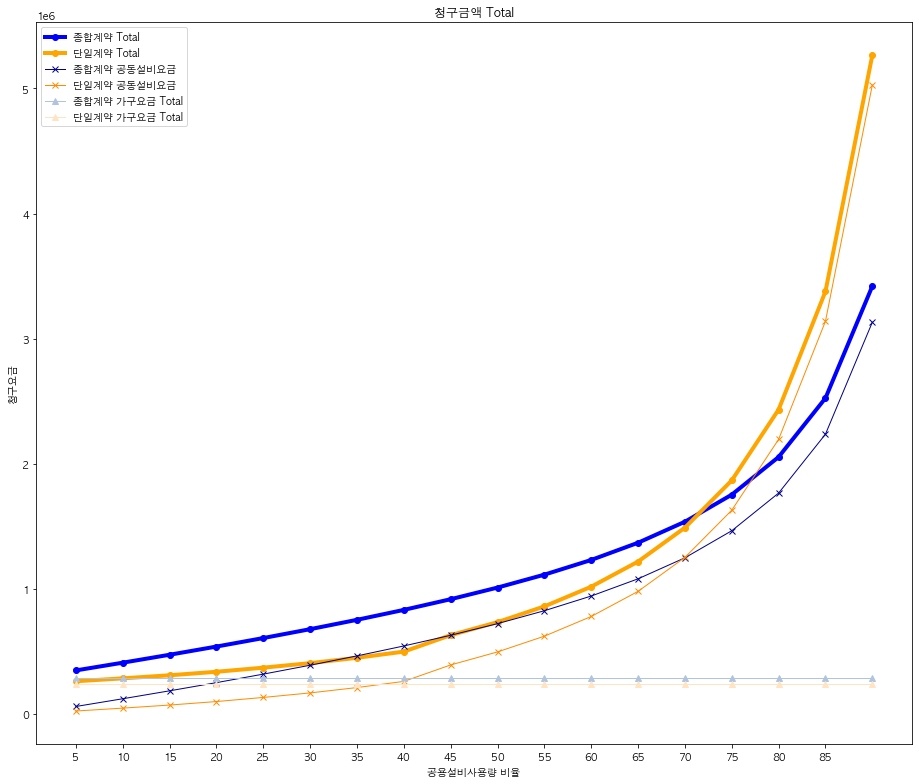

In [110]:
x = kepco_report_df['PUBLIC PERCENTAGE'].values
comp_y = kepco_report_df[clean_col_2]['종합계약 Total'].values
single_y = kepco_report_df[clean_col_2]['단일계약 Total'].values

comp_hh_y = kepco_report_df[clean_col_1_ext_1]['종합계약 가구요금 Total'].values
single_hh_y = kepco_report_df[clean_col_1_ext_1]['단일계약 가구요금 Total'].values

comp_pub_y = kepco_report_df[clean_col_1_ext_1]['종합계약 공동설비요금'].values
single_pub_y = kepco_report_df[clean_col_1_ext_1]['단일계약 공동설비요금'].values

plt.plot(x, comp_y, label="종합계약 Total", linewidth=4, marker="o", color="blue")
plt.plot(x, single_y, label="단일계약 Total", linewidth=4, marker="o", color="orange")
plt.plot(x, comp_pub_y, label="종합계약 공동설비요금", linewidth=1, marker="x", color="darkblue")
plt.plot(x, single_pub_y, label="단일계약 공동설비요금", linewidth=1, marker="x", color="darkorange")
plt.plot(x, comp_hh_y, label="종합계약 가구요금 Total", linewidth=1, marker="^", color="lightsteelblue")
plt.plot(x, single_hh_y, label="단일계약 가구요금 Total", linewidth=1, marker="^", color="bisque")
plt.xticks(np.arange(START_STEP, LAST_STEP, 5))
plt.title("청구금액 Total")
plt.xlabel("공용설비사용량 비율")
plt.ylabel("청구요금")
plt.legend()

plt.show()

In [111]:
kepco_report_df[clean_col_3]

,종합계약 최소요금 가구 (name),종합계약 최소요금 가구 (kwh),종합계약 최소요금 가구 (전기요금),종합계약 최소요금 가구 (공동설비요금),종합계약 최소요금 가구 (최종청구금액),단일계약 최소요금 가구 (name),단일계약 최소요금 가구 (kwh),단일계약 최소요금 가구 (전기요금),단일계약 최소요금 가구 (공동설비요금),단일계약 최소요금 가구 (최종청구금액)
5%,101 호,150.0,11930.0,6009.0,17939.0,101 호,150.0,10870.0,2387.0,13257.0
10%,101 호,150.0,11930.0,12183.0,24113.0,101 호,150.0,10870.0,4689.0,15559.0
15%,101 호,150.0,11930.0,18525.0,30455.0,101 호,150.0,10870.0,7155.0,18025.0
20%,101 호,150.0,11930.0,25072.0,37002.0,101 호,150.0,10870.0,9951.0,20821.0
25%,101 호,150.0,11930.0,31872.0,43802.0,101 호,150.0,10870.0,13238.0,24108.0
30%,101 호,150.0,11930.0,38977.0,50907.0,101 호,150.0,10870.0,16856.0,27726.0
35%,101 호,150.0,11930.0,46446.0,58376.0,101 호,150.0,10870.0,21130.0,32000.0
40%,101 호,150.0,11930.0,54386.0,66316.0,101 호,150.0,10870.0,26062.0,36932.0
45%,101 호,150.0,11930.0,62928.0,74858.0,101 호,150.0,10870.0,39217.0,50087.0
50%,101 호,150.0,11930.0,72222.0,84152.0,101 호,150.0,10870.0,49624.0,60494.0


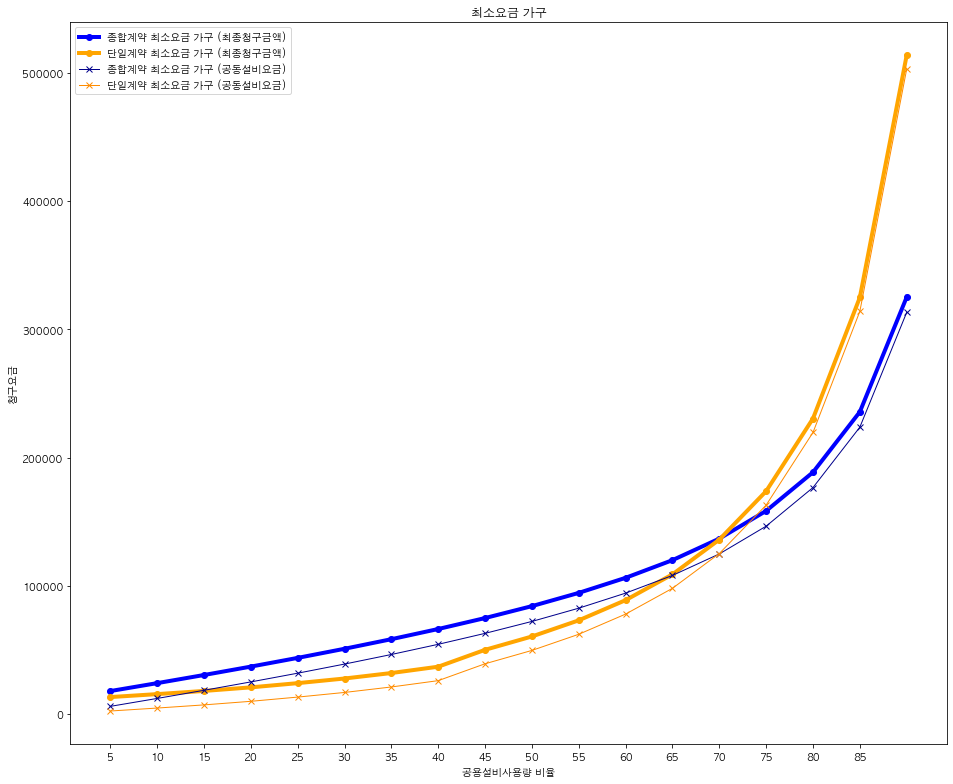

In [112]:
x = kepco_report_df['PUBLIC PERCENTAGE'].values

comp_min_y = kepco_report_df[clean_col_3]['종합계약 최소요금 가구 (최종청구금액)'].values
single_min_y = kepco_report_df[clean_col_3]['단일계약 최소요금 가구 (최종청구금액)'].values
comp_public_personal_y = kepco_report_df[clean_col_3]['종합계약 최소요금 가구 (공동설비요금)'].values
single_public_personal_y = kepco_report_df[clean_col_3]['단일계약 최소요금 가구 (공동설비요금)'].values

plt.plot(x, comp_min_y, label='종합계약 최소요금 가구 (최종청구금액)', linewidth=4, marker="o", color="blue")
plt.plot(x, single_min_y, label='단일계약 최소요금 가구 (최종청구금액)', linewidth=4, marker="o", color="orange")
plt.plot(x, comp_public_personal_y, label='종합계약 최소요금 가구 (공동설비요금)', linewidth=1, marker="x", color="darkblue")
plt.plot(x, single_public_personal_y, label='단일계약 최소요금 가구 (공동설비요금)', linewidth=1, marker="x", color="darkorange")
plt.xticks(np.arange(START_STEP, LAST_STEP, 5))
plt.title("최소요금 가구")
plt.xlabel("공용설비사용량 비율")
plt.ylabel("청구요금")
plt.legend()

plt.show()

In [113]:
kepco_report_df[clean_col_4]

,종합계약 최대요금 가구 (name),종합계약 최대요금 가구 (kwh),종합계약 최대요금 가구 (최종청구금액),종합계약 최대요금 가구 (전기요금),종합계약 최대요금 가구 (공동설비요금),단일계약 최대요금 가구 (name),단일계약 최대요금 가구 (kwh),단일계약 최대요금 가구 (최종청구금액),단일계약 최대요금 가구 (전기요금),단일계약 최대요금 가구 (공동설비요금)
5%,501 호,310.0,51589.0,45580.0,6009.0,501 호,310.0,39087.0,36700.0,2387.0
10%,501 호,310.0,57763.0,45580.0,12183.0,501 호,310.0,41389.0,36700.0,4689.0
15%,501 호,310.0,64105.0,45580.0,18525.0,501 호,310.0,43855.0,36700.0,7155.0
20%,501 호,310.0,70652.0,45580.0,25072.0,501 호,310.0,46651.0,36700.0,9951.0
25%,501 호,310.0,77452.0,45580.0,31872.0,501 호,310.0,49938.0,36700.0,13238.0
30%,501 호,310.0,84557.0,45580.0,38977.0,501 호,310.0,53556.0,36700.0,16856.0
35%,501 호,310.0,92026.0,45580.0,46446.0,501 호,310.0,57830.0,36700.0,21130.0
40%,501 호,310.0,99966.0,45580.0,54386.0,501 호,310.0,62762.0,36700.0,26062.0
45%,501 호,310.0,108508.0,45580.0,62928.0,501 호,310.0,75917.0,36700.0,39217.0
50%,501 호,310.0,117802.0,45580.0,72222.0,501 호,310.0,86324.0,36700.0,49624.0


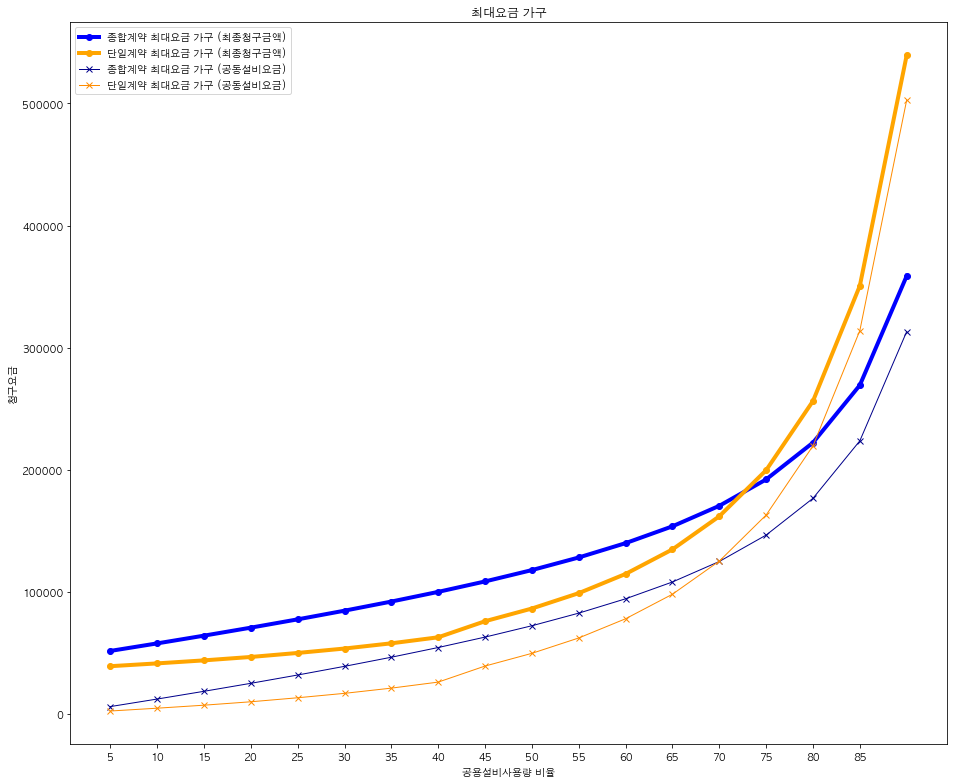

In [114]:
x = kepco_report_df['PUBLIC PERCENTAGE'].values

comp_max_y = kepco_report_df[clean_col_4]['종합계약 최대요금 가구 (최종청구금액)'].values
single_max_y = kepco_report_df[clean_col_4]['단일계약 최대요금 가구 (최종청구금액)'].values
comp_public_personal_y = kepco_report_df[clean_col_4]['종합계약 최대요금 가구 (공동설비요금)'].values
single_public_personal_y = kepco_report_df[clean_col_4]['단일계약 최대요금 가구 (공동설비요금)'].values

plt.plot(x, comp_max_y, label='종합계약 최대요금 가구 (최종청구금액)', linewidth=4, marker="o", color="blue")
plt.plot(x, single_max_y, label='단일계약 최대요금 가구 (최종청구금액)', linewidth=4, marker="o", color="orange")
plt.plot(x, comp_public_personal_y, label='종합계약 최대요금 가구 (공동설비요금)', linewidth=1, marker="x", color="darkblue")
plt.plot(x, single_public_personal_y, label='단일계약 최대요금 가구 (공동설비요금)', linewidth=1, marker="x", color="darkorange")
plt.xticks(np.arange(START_STEP, LAST_STEP, 5))
plt.title("최대요금 가구")
plt.xlabel("공용설비사용량 비율")
plt.ylabel("청구요금")
plt.legend()

plt.show()

In [115]:
# 최대값 로직 ( lambda 기억! )
basic_households = get_const_households(rate_type="종합계약")
max_household = max(basic_households, key = lambda h: h.kwh)
max_household.kwh += 100
basic_households[4].kwh

410

In [136]:
ran_idxes = list()
basic_households = get_const_households(rate_type="종합계약")

while len(ran_idxes) < 5:
    ran_idx = ran.randrange(0, len(basic_households))
    if ran_idx not in ran_idxes:
        ran_idxes.append(ran_idx)
        
ran_idxes

[7, 3, 1, 2, 9]

In [141]:
kepco_report_df = pd.DataFrame()
basic_report_dict = dict()
basic_households = get_const_households(rate_type="종합계약")
now_month = 2

START_STEP = 5
PERCENTAGE_STEP = 5
LAST_STEP = 90
HOUSEHOLD_RATE = sum([_.kwh for _ in basic_households])
HOUSEHOLD_RATE_100 = HOUSEHOLD_RATE * 100

household_name_list = [_.name for _ in basic_households]
PUBLIC_RATE = 660
PUBLIC_PERCENTAGE = PUBLIC_RATE / ALL_RATE

MAX_APT_METER = HOUSEHOLD_RATE * len(basic_households)
MAX_PROGRESSIVE_TAX_LINE = 4000
ALL_RATE = HOUSEHOLD_RATE + PUBLIC_RATE
INCREASE_VALUE = 150
INCREASE_COUNT_VALUE = 0
    
comprehensive_households = get_const_households(rate_type="종합계약")
single_households = get_const_households(rate_type="단일계약")
    
while ALL_RATE <= MAX_APT_METER:
    apply_max_progressive_tax = ALL_RATE - MAX_PROGRESSIVE_TAX_LINE
    if apply_max_progressive_tax < 0:
        apply_max_progressive_tax = 0
    print(
     "최고 누진세 적용량 (kwh): {}\n".format(apply_max_progressive_tax) +\
     "세대 사용량 (kwh): {}\n".format(HOUSEHOLD_RATE) +\
     "공용 사용량 (kwh): {}\n".format(PUBLIC_RATE) +\
     "전체 사용량 (kwh): {}\n".format(ALL_RATE))
    
    

    comp_mgmt = MGMTOFFICE(rate_type="종합계약", 
                      APT_METER=ALL_RATE, 
                      now_month=now_month,
                      households=comprehensive_households)
    single_mgmt = MGMTOFFICE(rate_type="단일계약", 
                      APT_METER=ALL_RATE, 
                      now_month=now_month,
                      households=single_households)
    
    comp_bill = comp_mgmt.bill()
    single_bill = single_mgmt.bill()
    
#     print(ALL_RATE,[_.kwh for _ in comprehensive_households])
    
    mgmt_office_row_name = "[{}월] 관리사무소 청구서".format(now_month)
    public_row_name = "[{}월] 공동사용설비요금".format(now_month)
    households_row_name = "[{}월] 세대 전체 요금 합산".format(now_month)
    
    basic_report_dict['APT METER'] = ALL_RATE
    basic_report_dict['HOUSEHOLD METER'] = HOUSEHOLD_RATE
    basic_report_dict['PUBLIC METER'] = PUBLIC_RATE
    basic_report_dict['PUBLIC PERCENTAGE'] = PUBLIC_PERCENTAGE
    basic_report_dict['최고 누진세 적용량 (kwh)'] = apply_max_progressive_tax
    basic_report_dict['종합계약 Total'] = comp_bill.loc[mgmt_office_row_name]['청구금액 (절사)']
    basic_report_dict['종합계약 가구요금 Total'] = comp_bill.loc[households_row_name]['청구금액 (절사)']
    basic_report_dict['종합계약 공동설비요금'] = comp_bill.loc[public_row_name]['청구금액 (절사)']
    basic_report_dict['종합계약 평균청구금액'] = round(comp_bill.loc[household_name_list]['최종청구금액'].mean())
    basic_report_dict['단일계약 Total'] = single_bill.loc[mgmt_office_row_name]['청구금액 (절사)']
    basic_report_dict['단일계약 가구요금 Total'] = single_bill.loc[households_row_name]['청구금액 (절사)']
    basic_report_dict['단일계약 공동설비요금'] = single_bill.loc[public_row_name]['청구금액 (절사)']
    basic_report_dict['단일계약 평균청구금액'] = round(single_bill.loc[household_name_list]['최종청구금액'].mean())
    
    comp_min = comp_bill.loc[household_name_list]['최종청구금액'].min()
    household_name = comp_bill[comp_bill['최종청구금액'] == comp_min].index[0]
    
    basic_report_dict['종합계약 최소요금 가구 (name)'] = household_name
    basic_report_dict['종합계약 최소요금 가구 (kwh)'] = comp_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['종합계약 최소요금 가구 (최종청구금액)'] = comp_min
    basic_report_dict['종합계약 최소요금 가구 (전기요금)'] = comp_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['종합계약 최소요금 가구 (공동설비요금)'] = comp_bill.loc[household_name]['공동전기사용료']
    
    single_min = single_bill.loc[household_name_list]['최종청구금액'].min()
    household_name = single_bill[single_bill['최종청구금액'] == single_min].index[0]
    basic_report_dict['단일계약 최소요금 가구 (name)'] = household_name
    basic_report_dict['단일계약 최소요금 가구 (kwh)'] = single_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['단일계약 최소요금 가구 (최종청구금액)'] = single_min
    basic_report_dict['단일계약 최소요금 가구 (전기요금)'] = single_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['단일계약 최소요금 가구 (공동설비요금)'] = single_bill.loc[household_name]['공동전기사용료']
    
    comp_max = comp_bill.loc[household_name_list]['최종청구금액'].max()
    household_name = comp_bill[comp_bill['최종청구금액'] == comp_max].index[0]
    
    basic_report_dict['종합계약 최대요금 가구 (name)'] = household_name
    basic_report_dict['종합계약 최대요금 가구 (kwh)'] = comp_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['종합계약 최대요금 가구 (최종청구금액)'] = comp_max
    basic_report_dict['종합계약 최대요금 가구 (전기요금)'] = comp_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['종합계약 최대요금 가구 (공동설비요금)'] = comp_bill.loc[household_name]['공동전기사용료']
    
    single_max = single_bill.loc[household_name_list]['최종청구금액'].max()
    household_name = single_bill[single_bill['최종청구금액'] == single_max].index[0]
    basic_report_dict['단일계약 최대요금 가구 (name)'] = household_name
    basic_report_dict['단일계약 최대요금 가구 (kwh)'] = single_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['단일계약 최대요금 가구 (최종청구금액)'] = single_max
    basic_report_dict['단일계약 최대요금 가구 (전기요금)'] = single_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['단일계약 최대요금 가구 (공동설비요금)'] = single_bill.loc[household_name]['공동전기사용료']
    
    kepco_report_df = kepco_report_df.append(
        pd.Series(
            basic_report_dict,
            name="+ {}".format(INCREASE_COUNT_VALUE)
        )
    )
    
    comprehensive_households = get_const_households(rate_type="종합계약")
    single_households = get_const_households(rate_type="단일계약")

    INCREASE_COUNT_VALUE += INCREASE_VALUE * len(ran_idxes)
    for ran_idx in ran_idxes:
        comprehensive_households[ran_idx].kwh += INCREASE_COUNT_VALUE / len(ran_idxes)
        single_households[ran_idx].kwh += INCREASE_COUNT_VALUE / len(ran_idxes)
    
    HOUSEHOLD_RATE = sum([_.kwh for _ in comprehensive_households])
    ALL_RATE = HOUSEHOLD_RATE + PUBLIC_RATE
    PUBLIC_PERCENTAGE = PUBLIC_RATE / ALL_RATE

    IPython.display.clear_output()

In [142]:
kepco_report_df[['APT METER'] + progressive_col + clean_col_3]

,APT METER,최고 누진세 적용량 (kwh),종합계약 최소요금 가구 (name),종합계약 최소요금 가구 (kwh),종합계약 최소요금 가구 (전기요금),종합계약 최소요금 가구 (공동설비요금),종합계약 최소요금 가구 (최종청구금액),단일계약 최소요금 가구 (name),단일계약 최소요금 가구 (kwh),단일계약 최소요금 가구 (전기요금),단일계약 최소요금 가구 (공동설비요금),단일계약 최소요금 가구 (최종청구금액)
+ 0,3000.0,0.0,101 호,150.0,11930.0,27760.0,39690.0,101 호,150.0,10870.0,11266.0,22136.0
+ 750,3750.0,0.0,101 호,150.0,11930.0,23642.0,35572.0,101 호,150.0,10870.0,10186.0,21056.0
+ 1500,4500.0,500.0,101 호,150.0,11930.0,20898.0,32828.0,101 호,150.0,10870.0,13072.0,23942.0
+ 2250,5250.0,1250.0,101 호,150.0,11930.0,18937.0,30867.0,101 호,150.0,10870.0,13073.0,23943.0
+ 3000,6000.0,2000.0,101 호,150.0,11930.0,17466.0,29396.0,101 호,150.0,10870.0,13074.0,23944.0
+ 3750,6750.0,2750.0,101 호,150.0,11930.0,16323.0,28253.0,101 호,150.0,10870.0,13074.0,23944.0
+ 4500,7500.0,3500.0,101 호,150.0,11930.0,15408.0,27338.0,101 호,150.0,10870.0,13073.0,23943.0
+ 5250,8250.0,4250.0,101 호,150.0,11930.0,14660.0,26590.0,101 호,150.0,10870.0,13072.0,23942.0
+ 6000,9000.0,5000.0,101 호,150.0,11930.0,14035.0,25965.0,101 호,150.0,10870.0,13074.0,23944.0
+ 6750,9750.0,5750.0,101 호,150.0,11930.0,13507.0,25437.0,101 호,150.0,10870.0,13072.0,23942.0


In [143]:
kepco_report_df[['APT METER'] + progressive_col + clean_col_4]

,APT METER,최고 누진세 적용량 (kwh),종합계약 최대요금 가구 (name),종합계약 최대요금 가구 (kwh),종합계약 최대요금 가구 (전기요금),종합계약 최대요금 가구 (공동설비요금),종합계약 최대요금 가구 (최종청구금액),단일계약 최대요금 가구 (name),단일계약 최대요금 가구 (kwh),단일계약 최대요금 가구 (전기요금),단일계약 최대요금 가구 (공동설비요금),단일계약 최대요금 가구 (최종청구금액)
+ 0,3000.0,0.0,501 호,310.0,45580.0,27760.0,73340.0,501 호,310.0,36700.0,11266.0,47966.0
+ 750,3750.0,0.0,1001 호,410.0,74170.0,23642.0,97812.0,1001 호,410.0,59380.0,10186.0,69566.0
+ 1500,4500.0,500.0,1001 호,560.0,121560.0,20898.0,142458.0,1001 호,560.0,95690.0,13072.0,108762.0
+ 2250,5250.0,1250.0,1001 호,710.0,168960.0,18937.0,187897.0,1001 호,710.0,131990.0,13073.0,145063.0
+ 3000,6000.0,2000.0,1001 호,860.0,216360.0,17466.0,233826.0,1001 호,860.0,168300.0,13074.0,181374.0
+ 3750,6750.0,2750.0,1001 호,1010.0,263750.0,16323.0,280073.0,1001 호,1010.0,204610.0,13074.0,217684.0
+ 4500,7500.0,3500.0,1001 호,1160.0,311150.0,15408.0,326558.0,1001 호,1160.0,240930.0,13073.0,254003.0
+ 5250,8250.0,4250.0,1001 호,1310.0,358540.0,14660.0,373200.0,1001 호,1310.0,277240.0,13072.0,290312.0
+ 6000,9000.0,5000.0,1001 호,1460.0,405940.0,14035.0,419975.0,1001 호,1460.0,313550.0,13074.0,326624.0
+ 6750,9750.0,5750.0,1001 호,1610.0,453340.0,13507.0,466847.0,1001 호,1610.0,349860.0,13072.0,362932.0


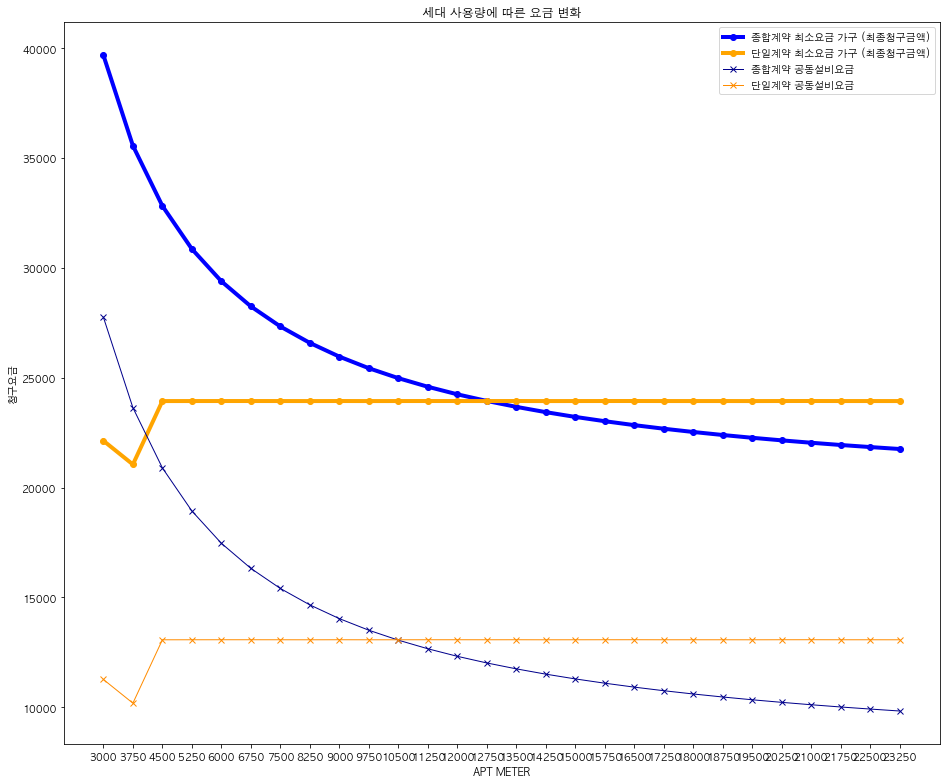

In [149]:
x = kepco_report_df['APT METER'].values

comp_min_y = kepco_report_df['종합계약 최소요금 가구 (최종청구금액)']
single_min_y = kepco_report_df['단일계약 최소요금 가구 (최종청구금액)']
comp_max_y = kepco_report_df['종합계약 최대요금 가구 (최종청구금액)']
single_max_y = kepco_report_df['단일계약 최대요금 가구 (최종청구금액)']

comp_pub_y = kepco_report_df['종합계약 최소요금 가구 (공동설비요금)']
single_pub_y = kepco_report_df['단일계약 최소요금 가구 (공동설비요금)']

plt.plot(x, comp_min_y, label='종합계약 최소요금 가구 (최종청구금액)', linewidth=4, marker="o", color="blue")
plt.plot(x, single_min_y, label='단일계약 최소요금 가구 (최종청구금액)', linewidth=4, marker="o", color="orange")
# plt.plot(x, comp_max_y, label='종합계약 최소요금 가구 (최종청구금액)', linewidth=4, marker="o", color="blue")
# plt.plot(x, single_max_y, label='단일계약 최소요금 가구 (최종청구금액)', linewidth=4, marker="o", color="orange")
plt.plot(x, comp_pub_y, label='종합계약 공동설비요금', linewidth=1, marker="x", color="darkblue")
plt.plot(x, single_pub_y, label='단일계약 공동설비요금', linewidth=1, marker="x", color="darkorange")
plt.xticks(x)
plt.title("세대 사용량에 따른 요금 변화")
plt.xlabel("APT METER")
plt.ylabel("청구요금")
plt.legend()

plt.show()

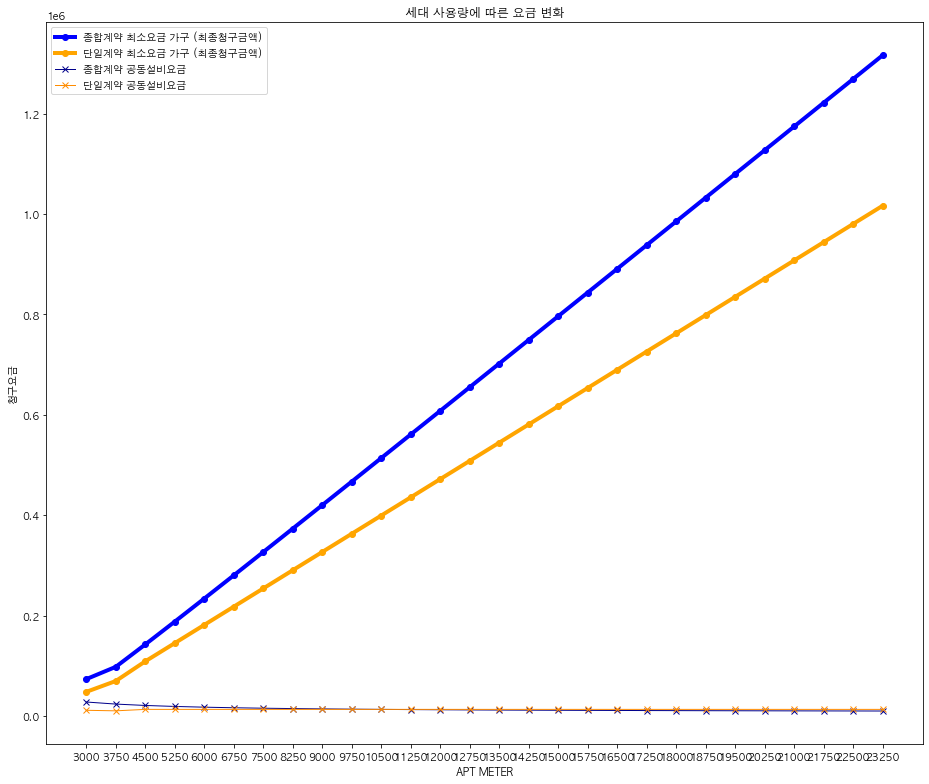

In [150]:
x = kepco_report_df['APT METER'].values

comp_max_y = kepco_report_df['종합계약 최대요금 가구 (최종청구금액)']
single_max_y = kepco_report_df['단일계약 최대요금 가구 (최종청구금액)']

plt.plot(x, comp_max_y, label='종합계약 최소요금 가구 (최종청구금액)', linewidth=4, marker="o", color="blue")
plt.plot(x, single_max_y, label='단일계약 최소요금 가구 (최종청구금액)', linewidth=4, marker="o", color="orange")
plt.plot(x, comp_pub_y, label='종합계약 공동설비요금', linewidth=1, marker="x", color="darkblue")
plt.plot(x, single_pub_y, label='단일계약 공동설비요금', linewidth=1, marker="x", color="darkorange")
plt.xticks(x)
plt.title("세대 사용량에 따른 요금 변화")
plt.xlabel("APT METER")
plt.ylabel("청구요금")
plt.legend()

plt.show()

In [12]:
DB = KETIDB()
DB.connect()
datas = DB.find()
household_name_list = datas.columns.values

### DB FIND START ###
### Data Process (dict -> dataframe) START ###
### DB FIND SUCCESS :) ###


In [68]:
basic_report_df = pd.DataFrame()
basic_report_dict = dict()

now_month = 1
ds = DPPSUPPORTER(datas=datas, now_month=now_month)

START_STEP = 5
PERCENTAGE_STEP = 5
LAST_STEP = 90
HOUSEHOLD_RATE = ds.sum_df.sum(axis=1)['kwh'] 
HOUSEHOLD_RATE_100 = HOUSEHOLD_RATE * 100

for PUBLIC_PERCENTAGE in range(START_STEP, LAST_STEP + PERCENTAGE_STEP, PERCENTAGE_STEP):
    ALL_RATE = round(HOUSEHOLD_RATE_100 / (100 - PUBLIC_PERCENTAGE))
    PUBLIC_RATE = ALL_RATE - HOUSEHOLD_RATE
    
    print("공용 사용량 차지비율: {}%\n".format(PUBLIC_PERCENTAGE) +\
     "세대 사용량 (kwh): {}\n".format(HOUSEHOLD_RATE) +\
     "공용 사용량 (kwh): {}\n".format(PUBLIC_RATE) +\
     "전체 사용량 (kwh): {}\n".format(ALL_RATE))
    
    comprehensive_households = ds.get_households(rate_type="종합계약")
    single_households = ds.get_households(rate_type="단일계약")

    comp_mgmt = MGMTOFFICE(rate_type="종합계약", 
                      APT_METER=ALL_RATE, 
                      now_month=now_month,
                      households=comprehensive_households,
                      peak_df=ds.peak_df)
    single_mgmt = MGMTOFFICE(rate_type="단일계약", 
                      APT_METER=ALL_RATE, 
                      now_month=now_month,
                      households=single_households,
                      peak_df=ds.peak_df)
    
    comp_bill = comp_mgmt.bill()
    single_bill = single_mgmt.bill()
    
    mgmt_office_row_name = "[{}월] 관리사무소 청구서".format(now_month)
    
    basic_report_dict['APT METER'] = ALL_RATE
    basic_report_dict['HOUSEHOLD METER'] = HOUSEHOLD_RATE
    basic_report_dict['PUBLIC METER'] = PUBLIC_RATE
    basic_report_dict['PUBLIC PERCENTAGE'] = PUBLIC_PERCENTAGE
    basic_report_dict['종합계약 Total'] = comp_bill.loc[mgmt_office_row_name]['청구금액 (절사)']
    basic_report_dict['종합계약 평균청구금액'] = round(comp_bill.loc[household_name_list]['최종청구금액'].mean())
    basic_report_dict['단일계약 Total'] = single_bill.loc[mgmt_office_row_name]['청구금액 (절사)']
    basic_report_dict['단일계약 평균청구금액'] = round(single_bill.loc[household_name_list]['최종청구금액'].mean())
    
    comp_min = comp_bill.loc[household_name_list]['최종청구금액'].min()
    household_name = comp_bill[comp_bill['최종청구금액'] == comp_min].index[0]
    
    basic_report_dict['종합계약 최소요금 가구 (name)'] = household_name
    basic_report_dict['종합계약 최소요금 가구 (kwh)'] = comp_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['종합계약 최소요금 가구 (최종청구금액)'] = comp_min
    basic_report_dict['종합계약 최소요금 가구 (전기요금)'] = comp_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['종합계약 최소요금 가구 (공동설비요금)'] = comp_bill.loc[household_name]['공동전기사용료']
    
    single_min = single_bill.loc[household_name_list]['최종청구금액'].min()
    household_name = single_bill[single_bill['최종청구금액'] == single_min].index[0]
    basic_report_dict['단일계약 최소요금 가구 (name)'] = household_name
    basic_report_dict['단일계약 최소요금 가구 (kwh)'] = single_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['단일계약 최소요금 가구 (최종청구금액)'] = single_min
    basic_report_dict['단일계약 최소요금 가구 (전기요금)'] = single_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['단일계약 최소요금 가구 (공동설비요금)'] = single_bill.loc[household_name]['공동전기사용료']
    
    comp_max = comp_bill.loc[household_name_list]['최종청구금액'].max()
    household_name = comp_bill[comp_bill['최종청구금액'] == comp_max].index[0]
    
    basic_report_dict['종합계약 최대요금 가구 (name)'] = household_name
    basic_report_dict['종합계약 최대요금 가구 (kwh)'] = comp_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['종합계약 최대요금 가구 (최종청구금액)'] = comp_max
    basic_report_dict['종합계약 최대요금 가구 (전기요금)'] = comp_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['종합계약 최대요금 가구 (공동설비요금)'] = comp_bill.loc[household_name]['공동전기사용료']
    
    single_max = single_bill.loc[household_name_list]['최종청구금액'].max()
    household_name = single_bill[single_bill['최종청구금액'] == single_max].index[0]
    basic_report_dict['단일계약 최대요금 가구 (name)'] = household_name
    basic_report_dict['단일계약 최대요금 가구 (kwh)'] = single_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['단일계약 최대요금 가구 (최종청구금액)'] = single_max
    basic_report_dict['단일계약 최대요금 가구 (전기요금)'] = single_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['단일계약 최대요금 가구 (공동설비요금)'] = single_bill.loc[household_name]['공동전기사용료']
    
    basic_report_df = basic_report_df.append(
        pd.Series(
            basic_report_dict,
            name="{}%".format(PUBLIC_PERCENTAGE)
        )
    )
    
    IPython.display.clear_output()

In [69]:
basic_report_df[clean_col_2]

,종합계약 Total,종합계약 평균청구금액,단일계약 Total,단일계약 평균청구금액
5%,17021850.0,42769.0,13694440.0,34408.0
10%,17901700.0,44980.0,14806250.0,37201.0
15%,18865610.0,47401.0,15984790.0,40162.0
20%,19928940.0,50073.0,17358500.0,43614.0
25%,21111870.0,53045.0,18864060.0,47397.0
30%,22439880.0,56382.0,22802720.0,57293.0
35%,23946630.0,60168.0,24831040.0,62389.0
40%,25676500.0,64514.0,27186940.0,68309.0
45%,27690620.0,69575.0,30000380.0,75378.0
50%,30074090.0,75563.0,33337680.0,83763.0


In [54]:
basic_20_30_report_df = pd.DataFrame()
basic_report_dict = dict()

now_month = 1
ds = DPPSUPPORTER(datas=datas, now_month=now_month)

START_STEP = 5
PERCENTAGE_STEP = 5
LAST_STEP = 90
HOUSEHOLD_RATE = ds.sum_df.sum(axis=1)['kwh'] 
HOUSEHOLD_RATE_100 = HOUSEHOLD_RATE * 100

for PUBLIC_PERCENTAGE in range(START_STEP, LAST_STEP + PERCENTAGE_STEP, PERCENTAGE_STEP):
    ALL_RATE = round(HOUSEHOLD_RATE_100 / (100 - PUBLIC_PERCENTAGE))
    PUBLIC_RATE = ALL_RATE - HOUSEHOLD_RATE
    
    print("공용 사용량 차지비율: {}%\n".format(PUBLIC_PERCENTAGE) +\
     "세대 사용량 (kwh): {}\n".format(HOUSEHOLD_RATE) +\
     "공용 사용량 (kwh): {}\n".format(PUBLIC_RATE) +\
     "전체 사용량 (kwh): {}\n".format(ALL_RATE))
    
    comprehensive_households = ds.get_households(rate_type="종합계약")
    single_households = ds.get_households(rate_type="단일계약")

    comp_mgmt = MGMTOFFICE(rate_type="종합계약", 
                      APT_METER=ALL_RATE, 
                      now_month=now_month,
                      households=comprehensive_households,
                      peak_df=ds.peak_df)
    single_mgmt = MGMTOFFICE(rate_type="단일계약", 
                      APT_METER=ALL_RATE, 
                      now_month=now_month,
                      households=single_households,
                      peak_df=ds.peak_df)
    
    comp_bill = comp_mgmt.bill()
    single_bill = single_mgmt.bill()
    
    mgmt_office_row_name = "[{}월] 관리사무소 청구서".format(now_month)
    
    basic_report_dict['APT METER'] = ALL_RATE
    basic_report_dict['HOUSEHOLD METER'] = HOUSEHOLD_RATE
    basic_report_dict['PUBLIC METER'] = PUBLIC_RATE
    basic_report_dict['PUBLIC PERCENTAGE'] = PUBLIC_PERCENTAGE
    basic_report_dict['종합계약 Total'] = comp_bill.loc[mgmt_office_row_name]['청구금액 (절사)']
    basic_report_dict['종합계약 평균청구금액'] = round(comp_bill.loc[household_name_list]['최종청구금액'].mean())
    basic_report_dict['단일계약 Total'] = single_bill.loc[mgmt_office_row_name]['청구금액 (절사)']
    basic_report_dict['단일계약 평균청구금액'] = round(single_bill.loc[household_name_list]['최종청구금액'].mean())
    
    comp_min = comp_bill.loc[household_name_list]['최종청구금액'].min()
    household_name = comp_bill[comp_bill['최종청구금액'] == comp_min].index[0]
    
    basic_report_dict['종합계약 최소요금 가구 (name)'] = household_name
    basic_report_dict['종합계약 최소요금 가구 (kwh)'] = comp_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['종합계약 최소요금 가구 (최종청구금액)'] = comp_min
    basic_report_dict['종합계약 최소요금 가구 (전기요금)'] = comp_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['종합계약 최소요금 가구 (공동설비요금)'] = comp_bill.loc[household_name]['공동전기사용료']
    
    single_min = single_bill.loc[household_name_list]['최종청구금액'].min()
    household_name = single_bill[single_bill['최종청구금액'] == single_min].index[0]
    basic_report_dict['단일계약 최소요금 가구 (name)'] = household_name
    basic_report_dict['단일계약 최소요금 가구 (kwh)'] = single_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['단일계약 최소요금 가구 (최종청구금액)'] = single_min
    basic_report_dict['단일계약 최소요금 가구 (전기요금)'] = single_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['단일계약 최소요금 가구 (공동설비요금)'] = single_bill.loc[household_name]['공동전기사용료']
    
    comp_max = comp_bill.loc[household_name_list]['최종청구금액'].max()
    household_name = comp_bill[comp_bill['최종청구금액'] == comp_max].index[0]
    
    basic_report_dict['종합계약 최대요금 가구 (name)'] = household_name
    basic_report_dict['종합계약 최대요금 가구 (kwh)'] = comp_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['종합계약 최대요금 가구 (최종청구금액)'] = comp_max
    basic_report_dict['종합계약 최대요금 가구 (전기요금)'] = comp_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['종합계약 최대요금 가구 (공동설비요금)'] = comp_bill.loc[household_name]['공동전기사용료']
    
    single_max = single_bill.loc[household_name_list]['최종청구금액'].max()
    household_name = single_bill[single_bill['최종청구금액'] == single_max].index[0]
    basic_report_dict['단일계약 최대요금 가구 (name)'] = household_name
    basic_report_dict['단일계약 최대요금 가구 (kwh)'] = single_bill.loc[household_name]['사용량 (kwh)']
    basic_report_dict['단일계약 최대요금 가구 (최종청구금액)'] = single_max
    basic_report_dict['단일계약 최대요금 가구 (전기요금)'] = single_bill.loc[household_name]['청구금액 (절사)']
    basic_report_dict['단일계약 최대요금 가구 (공동설비요금)'] = single_bill.loc[household_name]['공동전기사용료']
    
    basic_20_30_report_df = basic_report_df.append(
        pd.Series(
            basic_report_dict,
            name="{}%".format(PUBLIC_PERCENTAGE)
        )
    )
    
    IPython.display.clear_output()

In [56]:
basic_20_30_report_df[clean_col_2]

,종합계약 최대요금 가구 (name),종합계약 최대요금 가구 (kwh),종합계약 최대요금 가구 (최종청구금액),종합계약 최대요금 가구 (전기요금),종합계약 최대요금 가구 (공동설비요금),단일계약 최대요금 가구 (name),단일계약 최대요금 가구 (kwh),단일계약 최대요금 가구 (최종청구금액),단일계약 최대요금 가구 (전기요금),단일계약 최대요금 가구 (공동설비요금)
20%,아파트1-102-903,711.0,178606.0,169270.0,9336.0,아파트1-102-903,711.0,143158.0,132240.0,10918.0
21%,아파트1-102-903,711.0,179175.0,169270.0,9905.0,아파트1-102-903,711.0,143817.0,132240.0,11577.0
22%,아파트1-102-903,711.0,179756.0,169270.0,10486.0,아파트1-102-903,711.0,144638.0,132240.0,12398.0
23%,아파트1-102-903,711.0,180350.0,169270.0,11080.0,아파트1-102-903,711.0,145297.0,132240.0,13057.0
24%,아파트1-102-903,711.0,180957.0,169270.0,11687.0,아파트1-102-903,711.0,146119.0,132240.0,13879.0
25%,아파트1-102-903,711.0,181578.0,169270.0,12308.0,아파트1-102-903,711.0,146941.0,132240.0,14701.0
26%,아파트1-102-903,711.0,182214.0,169270.0,12944.0,아파트1-102-903,711.0,147764.0,132240.0,15524.0
27%,아파트1-102-903,711.0,182865.0,169270.0,13595.0,아파트1-102-903,711.0,148747.0,132240.0,16507.0
28%,아파트1-102-903,711.0,183532.0,169270.0,14262.0,아파트1-102-903,711.0,149571.0,132240.0,17331.0
29%,아파트1-102-903,711.0,184215.0,169270.0,14945.0,아파트1-102-903,711.0,150394.0,132240.0,18154.0
